<a href="https://colab.research.google.com/github/shakir507/BacklogModels/blob/main/PhaseSpaceExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Phase Soace Exploration: Number of excess resources during a surge
This code investigates the parameter space of the backlog-resource model for healthcare, exploring work hours and the amplitude of demand surges to determine the resources required. A surge is assumed to occur against the base demand for a time period 'P', after which demand returns to the base level.

In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt


In [10]:

# Parameters for the backlog

initial_backlog = 2  # Initial number of patients in the backlog
initial_resource = 2  # Initial number of resources
T0 = 1  # Initial time
Tf = 200  # Final time
time_span = (T0, Tf)  # Time range for simulation
time_points_backlog = np.linspace(time_span[0], time_span[1], 10000)  # Time points for evaluation
demandsurge = 600
basedemand = 100
period = 90  # Period of the surge
t1 = 50  # Start of the surge
t2 = t1 + period  # End of the surge
# counting number of time points between t1 and t2 based on time_points_backlog
timepoints_t1_t2 = time_points_backlog[(time_points_backlog >= t1) & (time_points_backlog <= t2)]
print("Number of time points between t1 and t2:", len(timepoints_t1_t2))
time_points_SIR = np.linspace(t1, t2, len(timepoints_t1_t2))  # Time points for evaluation

# Parameters for the SIR model
beta = 0.6  # Infection rate
gamma = 0.4  # Recovery rate
Ntot = 10000  # Total population
# -----------Parameters for resources
Wd = 5
Wh = 10
deliverydelay = 1 / 50
productivity = 1
R0 = 2
RAT = 1  # Resource Allocation Time
# -------------------------------------------


Number of time points between t1 and t2: 4522


In [3]:

def resources(t, dCp):
    # Using Heaviside for step functions
    dNr = dCp / (Wd * Wh)
    return dNr

def resource_error(t, Cp, C):
    return (Cp - C) / (Wh * Wd * productivity)

# Define the time-dependent growth rate a(t)
def STEP(a0, t, t0):
    return a0 * np.heaviside(t - t0, 0)

In [4]:

def SIR(t, Y, beta, gamma):
    S, I, R = Y
    dS_dt = -beta * S * I
    dI_dt = beta * S * I - gamma * I
    dR_dt = gamma * I
    return [dS_dt, dI_dt, dR_dt]

def solve_SIR_direct(t1, t2):
    # Solve the SIR model only between t1 and t2
    time_span = (t1, t2)
    time_points = np.linspace(t1, t2, 1000)  # Time points for evaluation
    S0 = 1 - 1 / Ntot  # Initial susceptible population
    I0 = 1 / Ntot  # Initial infected population
    R0 = 0.0  # Initial recovered population
    Initial_conditions = [S0, I0, R0]
    solution = solve_ivp(
        SIR,
        time_span,
        Initial_conditions,
        t_eval=time_points,
        args=(beta, gamma),
        rtol=1e-6,
        atol=1e-6
    )
    solution.y[1] *= Ntot  # Scale infected population to actual size
    return time_points, solution.y[1]  # Return time points and infected population


In [5]:

def demandsurge_function(demandsurge,fn=1):
    if fn == 1 or fn == 2:
        return demandsurge
    if fn == 3:
        t_sir, I_sir = solve_SIR_direct(t1, t2)  # Get time points and infected population
        return t_sir, I_sir

def demand(t, delta, fn=1):
    if fn == 1:
        return basedemand + STEP(delta, t, t1) - STEP(delta, t, t1 + period)  # Square wave
    if fn == 2:
        return basedemand + (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period))) * STEP(1, t, t1) - STEP(1, t, t1 + period) * (1 + delta * np.sin(2 * np.pi * (t - t1) / (2 * period)))  # Sinusoidal
    elif fn == 3:  # SIR-based demand
        t_sir, I_sir = delta  # Unpack time points and infected population
        if t < t1:  # Constant demand before t1
            return basedemand
        elif t > t2:  # Constant demand after t2
            return basedemand
        else:  # Use SIR dynamics between t1 and t2
            idx = np.searchsorted(t_sir, t)  # Find the closest SIR time point
            return basedemand + I_sir[idx]

# Define the ODE for customer growth
def backloghospital(t, Y, demandsurge, fn=1):
    B, R = Y
    a = demand(t, demandsurge_function(demandsurge,fn), fn)  # Get the time-dependent growth rate
    MaximumDemandFullfilled = B / deliverydelay
    C0 = R * Wd * Wh
    C = C0
    Cp = MaximumDemandFullfilled  # Target capacity required to meet backlog demand
    d = min(MaximumDemandFullfilled, C)  # Demand met
    dB_dt = a - d  # Change in backlog based on demand met and demand and demand surge
    dR_dt = (resource_error(t, Cp, C)) / RAT  # Change in resources based on shortage or surplus of resources to meet demand
    return [dB_dt, dR_dt]


In [11]:

# select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge
print("Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge")
fn = int(input("Enter the surge functional form:"))
#Run a loop over the surge amplitude and store the maximum resources required during the surge as a function of the surge amplitude.
max_resources = []
surge_amplitude = np.linspace(20, 600, 62)
for demandsurge in surge_amplitude:
    # Solve the ODE
    solution = solve_ivp(
        backloghospital,          # ODE function
        time_span,                # Time span
        [initial_backlog, initial_resource],     # Initial condition
        t_eval=time_points_backlog,       # Time points to evaluate the solution
        args=(demandsurge, fn,),  # Additional arguments for the ODE function
        rtol=1e-6,  # Reduce relative tolerance
        atol=1e-6   # Reduce absolute tolerance
    )

    # Extract results
    time = solution.t
    backlog = solution.y[0]
    resources_val = solution.y[1]
    #Compute maximum resources required during the surge from the solution and store
    max_resources.append(max(resources_val)-initial_resource)



Select a surge functional form fn=1 for square wave, fn=2 for sinusoidal or fn=3 to be simulated from a SIR model. The use can select the period of the surge
Enter the surge functional form:1


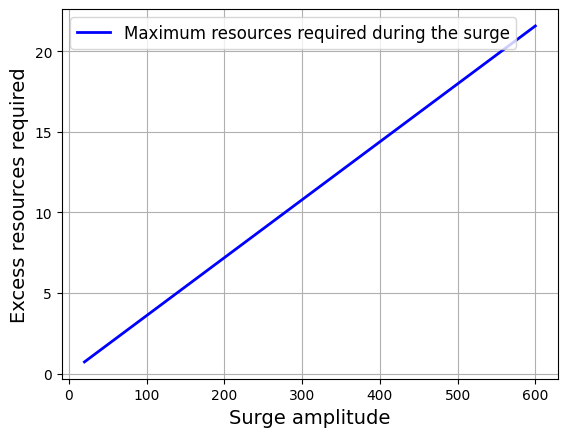

In [12]:
# Plot maximum resources required during the surge as a function of the surge amplitude
plt.plot(surge_amplitude, max_resources, label="Maximum resources required during the surge", color="blue", linewidth=2)
plt.xlabel("Surge amplitude", fontsize=14)
plt.ylabel("Excess resources required", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
